In [ ]:
На Kaggle мне удалось найти датасет, содержащий комментарии, размеченные на 

In [26]:
import pandas as pd
import numpy as np

data = pd.read_csv('labeled.csv')

data.tail()

,comment,toxic
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0
14411,До сих пор пересматриваю его видео. Орамбо кст...,0.0


In [2]:
data.shape

(14412, 2)

Проверим наличие пропусков в данных

In [3]:
data.isnull().any().any()

False

In [25]:
data['toxic'] = data['toxic'].astype('int32')
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


Посмотрим на распределение наших данных по классам (токсичные нетоксичные комментарии).

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

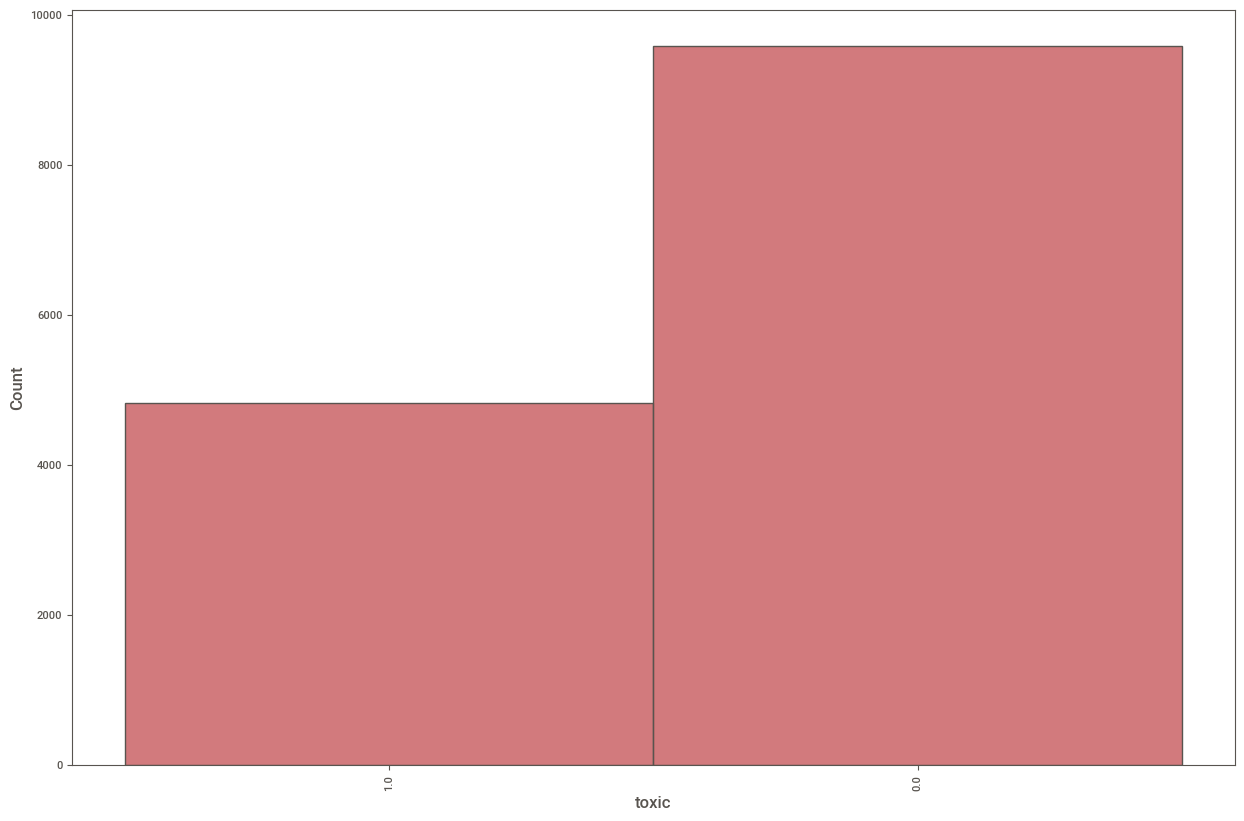

In [28]:
fig = plt.figure(figsize=(15, 10))
sns.histplot(data['toxic'].astype('str'), color='r')
plt.xticks(rotation=90)
plt.show()

Можем видеть, что классы распределены неравномерно -- число токсичных комментариев примерно в 2 раза меньше, чем обычных. А если быть точнее:

In [29]:
data['toxic'].value_counts()

0.0    9586
1.0    4826
Name: toxic, dtype: int64

Проверим качество разметки, выведя несколько токсичных и нетоксичных комментариев.

In [45]:
[print(text) for text in data[data['toxic'] == 0]['comment'][15:17]]

Не понимаю как так получается. 15-20 лет назад хватало времени прослушать все перечисленные группы и не по одному альбому. Это только метал. Ещё хватало времени на панк и хардкор. При этом помимо работы был ещё институт в то время. Сейчас же совсем времени нет на музыку. Куда девается свободное время?

Мне Вас очень жаль, если для Вас оскорбления - норма.



[None, None]

In [46]:
[print(text) for text in data[data['toxic'] == 1]['comment'][15:17]]

Я вообще мимо шёл. Вот сейчас поплачу над твоей головушкой, подзалупная истеричка, и дальше пойду. Ты такой же тупой и обманутый ванька как и те воеваки. То что вы глупые, невоспитанные, бедные, без прошлого и будущего и вас наебали на этот ресентимент ушлые чекисты и такие жирные приживалы как Гейгорка и Гоблач - всё это не снимает личной ответственности за свою жизнь и поступки. Очень вас жаль, но руки тебе не подам, отгрызёшь.

Мэдисон Тоже такой же стример Это такой троллинг или тебя мать в детстве роняла? Тебе нравится прикидываться тупым или ты просто тупой?



[None, None]

Больше смотреть не на что, так что разделим данные на `train` и `test` и займемся обработкой.

In [13]:
from sklearn.model_selection import train_test_split

In [172]:
X = data['comment']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from string import punctuation, digits

За стоп-символы будем считать знаки пунктуации и числа. Также удалим слова, которые в русском языке используются очень часто при помощи `stopwords.words('russian')`

Напишем свой кастомный tokenizer, который будет:
1. Приводить текст к нижнему регистру
2. Разбивать текст на токены
3. Удалять токены, содержащие стоп-символы или являющиеся стоп-словами
4. Проводить стемминг при помощи SnowballStemmer

In [50]:
stop_symb = punctuation + digits
stemmer = SnowballStemmer("russian")
sw = stopwords.words('russian')

In [51]:
def custom_tokenizer(s):
    s = [stemmer.stem(word) for word in word_tokenize(s.lower()) if word not in sw and word.translate(str.maketrans('', '', stop_symb)) == word]
    return s

Посмотрим на примере, что делает `custom_tokenizer`:

In [63]:
num_sample = 7
print(f"Исходный сэмпл: {X_train.iloc[num_sample]}\nРезультат: {custom_tokenizer(X_train.iloc[num_sample])}")

Исходный сэмпл: Согласен, но частично. Сейчас воруют в основном потому что почему бы и нет, а не от безысходности.

Результат: ['соглас', 'частичн', 'вор', 'основн', 'поч', 'безысходн']


Теперь токенизируем наши данные, используя `TfidfVectorizer` и наш катосмный токенайзер.

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [173]:
%%time
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train = vectorizer.fit_transform(X_train)
X_train.shape

Wall time: 15.4 s


(11529, 27812)

In [174]:
%%time
X_test = vectorizer.transform(X_test)
X_test.shape

Wall time: 4.11 s


(2883, 27812)

Настало время обучить модель. Для начала я выбрал логистическую регрессию, так как она неплохо справляется с классификацией и легко обучается.

In [68]:
from sklearn.linear_model import LogisticRegression

In [181]:
clf_lr = LogisticRegression(C=1.2)
clf_lr.fit(X_train, y_train)
y_predicted = clf_lr.predict(X_test)

In [133]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Посмотрим на метрики:

In [182]:
print(f"Метрики:\nAccuracy: {accuracy_score(y_test, y_predicted)}\nPrecision: {precision_score(y_test, y_predicted)}")
print(f"Recall: {recall_score(y_test, y_predicted)}\nF1: {f1_score(y_test, y_predicted)}")

Метрики:
Accuracy: 0.8595213319458896
Precision: 0.8903508771929824
Recall: 0.6485623003194888
F1: 0.7504621072088724


Как можно видеть, `recall` слишком низкий, в нашей задаче, пусть неточно, но лучше удалять больше комментариев, чем с большей точностью, но порпускать токсичные. Попробуем выбрать порог, где precision будет пониже, но еще вполне допустимый -- например, `0.8`:

In [183]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

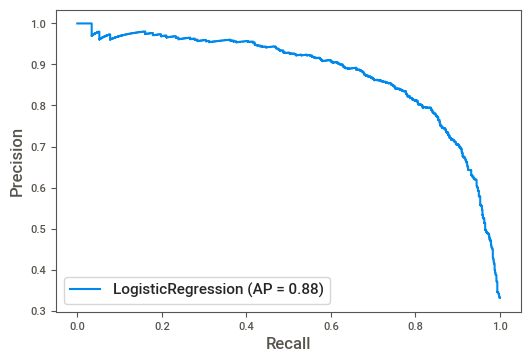

In [185]:
plot_precision_recall_curve(estimator=clf_lr, X=X_test, y=y_test)

In [186]:
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=clf_lr.predict_proba(X_test)[:, 1])

In [168]:
probas_pred = clf_lr.predict_proba(X_test)[:, 1] > thresholds[np.where(precision >= 0.8)[0][0]]

Посмотрим снова на метрики:

In [169]:
print(f"Метрики:\nAccuracy: {accuracy_score(y_test, probas_pred)}\nPrecision: {precision_score(y_test, probas_pred)}")
print(f"Recall: {recall_score(y_test, probas_pred)}\nF1: {f1_score(y_test, probas_pred)}")

Метрики:
Accuracy: 0.8740894901144641
Precision: 0.801255230125523
Recall: 0.8157614483493077
F1: 0.8084432717678101


Видим, что `recall` заметно возрос (0.6485$ \rightarrow$ 0.8157), при это также выросли `accuracy` и `f1`.

Построим также матрицу ошибок:

In [187]:
from sklearn.metrics import plot_confusion_matrix

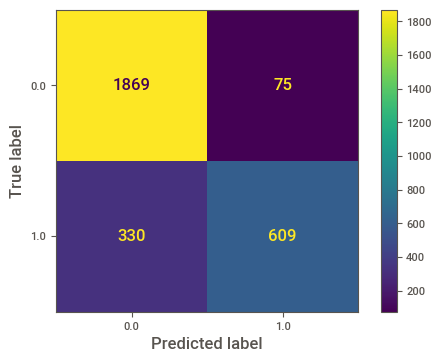

In [188]:
plot_confusion_matrix(clf_lr, X_test, y_test)

Видим, что у нас всего лишь 75 False Positive значений, то есть тех комментариев, которые являются токсичными, но модель их определила, как обычные.